In [ ]:
cd /content/drive/MyDrive/Fun With MNIST/MNIST-2 (Binary Label Classification)

/content/drive/MyDrive/Fun With MNIST/MNIST-2 (Binary Label Classification)


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten, Dropout, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
def create_dataset(dataset_size):
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x = np.concatenate((x_train, x_test), axis = 0)
    y = np.concatenate((y_train, y_test))
    print('Shape of the dataset after concatinating:')
    print(x.shape, y.shape)

    x_new = []
    y_new = []
    for _ in range(dataset_size):
        indices = np.random.randint(0, 70000, size = 2)
        new_image = np.concatenate((x[indices[0]], x[indices[1]]), axis = 1)
        x_new.append(new_image)

        ans1, ans2 = y[indices[0]], y[indices[1]]

        # new_y = [1 if z == ans1 or z == ans2 else 0 for z in range(10)]
        y_new.append((ans1, ans2))

    return x_new, y_new

In [3]:
dataset_size = 50000
x, y = create_dataset(dataset_size)

11493376/11490434 [==============================] - 0s 0us/step
Shape of the dataset after concatinating:
(70000, 28, 28) (70000,)


(3, 2)


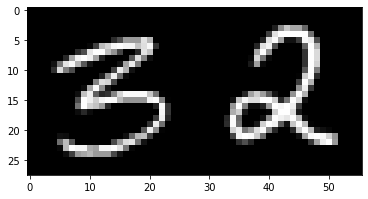

In [4]:
random = np.random.randint(dataset_size)
plt.imshow(x[random], cmap = 'gray')
print(y[random])

In [5]:
def ml_split(x, y):
    ml = MultiLabelBinarizer()
    y = ml.fit_transform(y)

    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [6]:
X_train, y_train, X_valid, y_valid, X_test, y_test = ml_split(x, y)

In [7]:
def print_shapes():
    print('Shapes of dataset:')
    print('Training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nValidation dataset:')
    print(X_valid.shape, y_valid.shape)
    print('\nTesting dataset:')
    print(X_test.shape, y_test.shape)

In [8]:
def format_input(features, labels):
    features = tf.convert_to_tensor(features)
    features = tf.expand_dims(features, axis = -1)

    labels = tf.convert_to_tensor(labels)

    return features, labels

In [9]:
X_train, y_train = format_input(X_train, y_train)
X_valid, y_valid = format_input(X_valid, y_valid)
X_test, y_test = format_input(X_test, y_test)

print_shapes()

Shapes of dataset:
Training dataset:
(32000, 28, 56, 1) (32000, 10)

Validation dataset:
(10000, 28, 56, 1) (10000, 10)

Testing dataset:
(8000, 28, 56, 1) (8000, 10)


In [10]:
def create_generator(bath_size, X_train, y_train, X_valid, y_valid, X_test, y_test):
    train_datagen = ImageDataGenerator(rescale = 1.0/255.0, dtype = 'float')

    valid_datagen = ImageDataGenerator(rescale = 1.0/255., dtype = 'float')

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle = True, seed = 42)
    valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size, seed = 42)
    test_generator = valid_datagen.flow(X_test, y_test, batch_size=batch_size, seed = 42)

    return train_generator, valid_generator, test_generator

In [11]:
batch_size = 256
train_generator, valid_generator, test_generator = create_generator(batch_size, X_train, y_train, X_valid, y_valid, X_test, y_test)

In [12]:
# define cnn model
def define_model(shape=(28, 56, 1), num_classes=10):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='he_uniform'))
    model.add(Dense(256, kernel_initializer='he_uniform'))
    model.add(Dense(128, kernel_initializer='he_uniform'))
    model.add(Dense(64, kernel_initializer='he_uniform'))
	# model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model
model = define_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 56, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 56, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 14, 64)         0

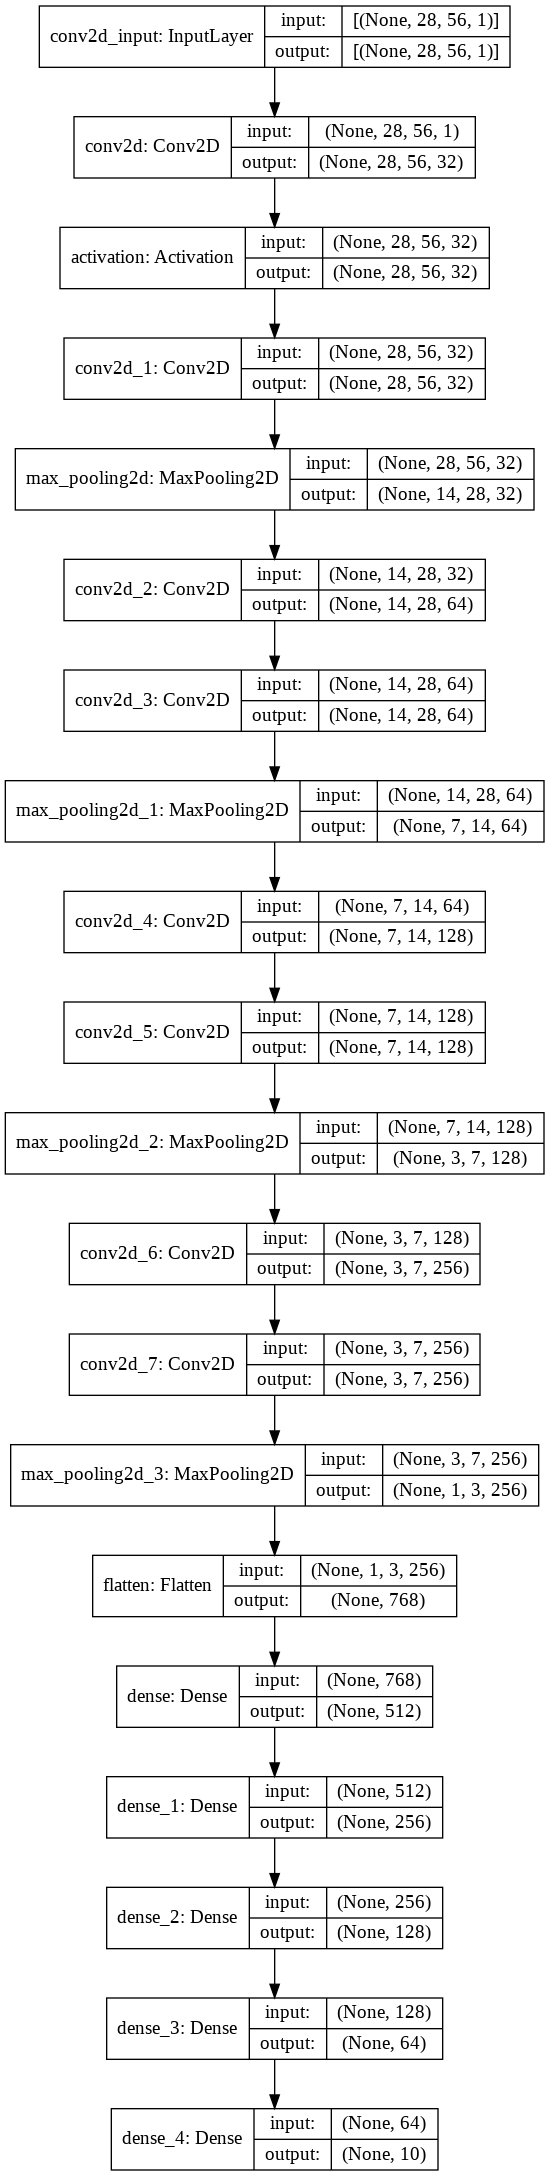

In [ ]:
plot_model(model, show_shapes = True)

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.75):
      print("\nReached 75% accuracy so cancelling training!")
      self.model.stop_training = True

es = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 20, verbose = 1, restore_best_weights=True,
                                      min_delta = 0.02)
callbacks = myCallback()

In [14]:
opt = tf.keras.optimizers.Adam(0.000001)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [16]:
epochs = 100

hist = model.fit(train_generator, epochs = epochs, validation_data = valid_generator, callbacks=[callbacks])

Epoch 1/100
125/125 [==============================] - 3s 27ms/step - loss: 0.1377 - accuracy: 0.6264 - val_loss: 0.1562 - val_accuracy: 0.6368
Epoch 2/100
125/125 [==============================] - 3s 27ms/step - loss: 0.1181 - accuracy: 0.6318 - val_loss: 0.1377 - val_accuracy: 0.6171
Epoch 3/100
125/125 [==============================] - 3s 27ms/step - loss: 0.1036 - accuracy: 0.6328 - val_loss: 0.1253 - val_accuracy: 0.6365
Epoch 4/100
125/125 [==============================] - 3s 27ms/step - loss: 0.0934 - accuracy: 0.6329 - val_loss: 0.1190 - val_accuracy: 0.6498
Epoch 5/100
125/125 [==============================] - 3s 27ms/step - loss: 0.0850 - accuracy: 0.6342 - val_loss: 0.1126 - val_accuracy: 0.6400
Epoch 6/100
125/125 [==============================] - 3s 26ms/step - loss: 0.0789 - accuracy: 0.6352 - val_loss: 0.1072 - val_accuracy: 0.6388
Epoch 7/100
125/125 [==============================] - 3s 27ms/step - loss: 0.0727 - accuracy: 0.6347 - val_loss: 0.1024 - val_accuracy:

In [ ]:
# outputLabels = np.unique(y_train)

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced', outputLabels, y_train) 
# classWeight = dict(enumerate(classWeight))
# model.fit(train_generator, epochs = epochs, validation_data = (valid_generator), class_weight=classWeight, callbacks=[callbacks, es])

In [17]:
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']

valid_acc = hist.history['val_accuracy']
valid_loss = hist.history['val_loss']
epochs = range(len(train_acc))

Text(0.5, 1.0, 'Accuracy')

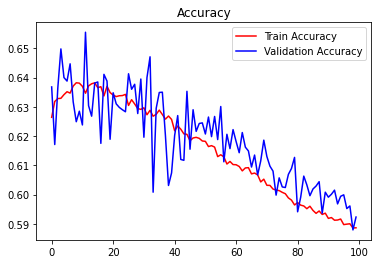

In [18]:
plt.plot(epochs, train_acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

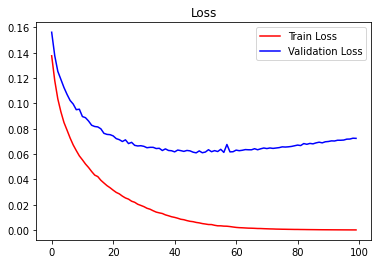

In [19]:
plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
plt.legend()
plt.title('Loss')

In [20]:
loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
print(loss)
print(int(accuracy * 100), '%')

32/32 [==============================] - 0s 11ms/step - loss: 0.0747 - accuracy: 0.5755
0.0746692419052124
57 %


In [ ]:
model.save('mnist-2-2.h5')